# PhyParts PieCharts

## *Making sense of gene tree conflict*

How do we assess support on phylogenies reconstructed from genome-scale data? To date, the most common method for assessing support involves bootstrapping sequence alignments. For one or a few genes, the bootstrapping approach ([first described by Felsenstein](http://statweb.stanford.edu/~nzhang/Stat366/Felsenstein85.pdf) in [one of the most-cited papers of all time](http://www.nature.com/news/the-top-100-papers-1.16224)), applies a statistical approach  common for small datasets. Creating pseudoreplicates of the data is essentially asking: "is my small sample representative of what could be expected if I had more data?" In general, the phylogenetics community settled upon an understanding that 70% bootstrap support was "okay" and 90% was "good."

In the low-cost genome sequencing world, we do have more data even for non-model organisms, and it is changing how we think about assessing support for phylogenies constructed from hundreds or thousands of genes. Phylogeneticists have come to grips with what the theoretical population genetics folks have been saying for decades: genes can have different histories, and gene histories can directly conflict species histories. One troubling finding suggests that simply treating every gene as if it has the same history (the concatenated supermatrix approach) [can be positively misleading in the presence of incomplete lineage sorting](http://www.ncbi.nlm.nih.gov/pubmed/20525567). Among other things, it means that bootstrap support on genomic-scale phylogenetic datasets may be massively inflated, or even have high support for the "wrong" topology. Each of the genes may be telling a different story.

## Assessing Gene Tree Conflict With Pie Charts

Last year, [Stephen Smith et al. published a paper](http://bmcevolbiol.biomedcentral.com/articles/10.1186/s12862-015-0423-0) describing methods that should be used to disentangle those different stories. They describe methods for assessing whether gene tree topologies are concordant or conflicting with a given species topology. Figure 2 in their paper shows an excellent visualization of this gene tree support and conflict. The pie charts on each node correspond to the proportion of gene trees that are:

![smith_pies](https://static-content.springer.com/image/art%3A10.1186%2Fs12862-015-0423-0/MediaObjects/12862_2015_423_Fig2_HTML.gif)

###### Citation: Smith SA, Moore MJ, Brown JW, and Yang, Y. 2015. "Analysis of phylogenomic datasets reveals conflict, concordance, and gene duplications with examples from animals and plants." BMC Evol. Bio. 15:150. DOI: 10.116/s12862-015-0423-0

In the figure above, the pie charts represent the proportion of gene trees that:

* Blue: Support the shown topology
* Green: Conflict with the shown topology (most common conflicting bipartion)
* Red: Conflict with the shown topology (all other supported conflicting bipartitions)
* Gray: Have no support for conflicting bipartion

What's interesting about these pie charts is that they can tell you at a glance what level of support to expect from the gene trees. Is there one dominant topology in the gene trees, and not much conflict (lots of blue)? If there is conflict, is there one frequent alternative topology (big green slice), or many low-frequency topologies (big red slice)?

## PhyParts

Smith et al. implemented their concordance/conflict methods in a software package called [PhyParts](https://bitbucket.org/blackrim/phyparts). I tested it out using a dataset we're working on (reconstructing the backbone phylogeny of mosses, using 96 nuclear genes). The input is a set of (rooted) gene trees and a (rooted) species tree. The package is especially good at calculating the amount of conflict despite non-overlapping sets of taxa in the gene trees. It took about 20 minutes to run on all the gene trees, and it output a lot of useful information, including the species phylogeny with the amount of concordance and conflict as branch labels, and every conflicting bipartition and its frequency.

What it doesn't output: pie charts! In order to recreate something like Figure 2 in the Smith et al paper, I needed to write something myself. Sure, I could have asked the authors for their scripts, and I probably could have done something in R. But, I thought this was a good opportunity to teach myself the inner workings of the [ETE3 Python](http://etetoolkit.org/) package, which has a powerful API for tree manipulation and visualization.

When evaluating gene tree support for a species topology, it is important to consider the ratio of blue to green on the pie chart. A high green proportion means there is a dominant alternative topology which should be considered. A very small sliver of blue is also indicative of low overall support for the shown topology. In many cases, bootstrap values may be near 100% for this node, despite the lack of support in any one gene tree.





# Visualizing Phyparts Output

The input to Phyparts is a rooted species phylogeny and a directory containing rooted gene trees. For every bipartition (leaves descending from each side of a bifurcating branch) on the species phylogeny, Phyparts sorts the gene trees into categories based on whether the gene tree is concordant with the species tree or is conflictint with the species tree. Phyparts outputs several files describing the levels of concordance and conflict, and identifies each conflicting bipartition and its frequency.


In [1]:
%matplotlib inline
from ete3 import Tree, TreeStyle, TextFace,NodeStyle,faces, COLOR_SCHEMES

#Species Tree
sptree_file = "aa/moss_backone_aa_astral_collapsed_rerooted.tre"

#Phyparts Output Files
histfile = "aa/phyparts_aa_astral_collapsed.hist"
keyfile = "aa/phyparts_aa_astral_collapsed.node.key"
concon_treefile = "aa/phyparts_aa_astral_collapsed.concon.tre"
total_genes = 96.0

## Example: Phylogeny of mosses (Bryophyta)

To generate the moss species phylogeny, we first reconstructed gene trees from 96 nuclear amino acid alignments using RAxML. We rooted the gene trees using 1-4 outgroup sequences (from liverworts), and collapsed nodes with less than 30% bootstrap support. We then reconstructed the species tree using [ASTRAL](https://github.com/smirarab/ASTRAL) from the 96 collapsed, rooted gene trees. Almost all nodes have maximal support using ASTRAL's new [Local Posterior Probability](http://mbe.oxfordjournals.org/content/early/2016/05/12/molbev.msw079.short?rss=1).

First, let's load this species tree into ETE3. An important part of the powerful ETE3 tree-drawing engine is the ability to display all kinds of data on branches using NodeFaces. These are one aspect of the TreeStyle, which controls how the tree is displayed. One of the more basic NodeFaces is the TextFace, which (as the name implies) shows text. Which text goes on which branch is set using a naming function. In the first example, we'll show the ASTRAL LPP support values using the `bootstrap_fn`.

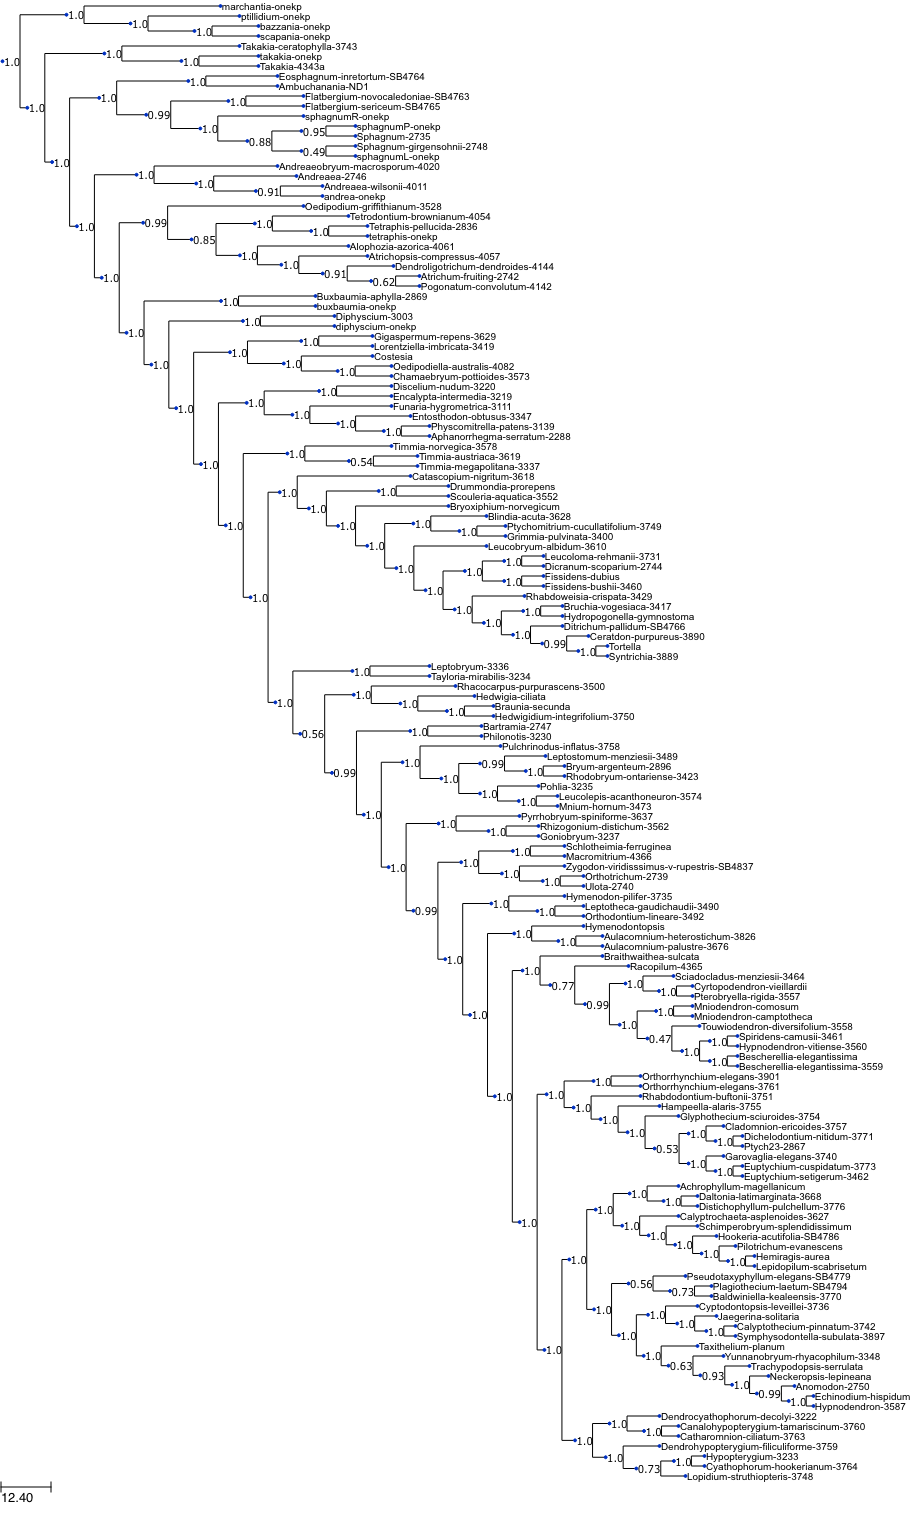

In [2]:
sptree = Tree(sptree_file)
sptree.convert_to_ultrametric()

def bootstrap_fn(mynode):
    if not mynode.is_leaf():
        F = TextFace(str(mynode.support))
        faces.add_face_to_node(F,mynode,0,"branch-top")

        

bs = TreeStyle()
bs.layout_fn = bootstrap_fn
bs.mode="r"
bs.show_leaf_name = True        


sptree.render("%%inline",tree_style=bs)


# Baking Pie Charts

The most critical task is to associate the nodes labeled by PhyParts with nodes on the ETE3 species tree.

Phyparts returns a "node key" file that associates the names of nodes with the subtree that descends from that node. For example:
```
Node0    ((H,I), A, (B,(C,(J, (F, D)))))
Node1    (J, (F, D))
Node2    (C,(J,(F,D)))
```
The conflict and concordance is also associated with these same node names in the "hist" file:
```
Node0,66.83333333333331,61
Node1,44.83333333333334,1.0,1.0,47
Node2,24.333333333333332,1.0,1.0,32
```

In order to plot the concordance and conflict information, we will need to name the nodes on our tree very specifically. To do this, we have to figure out how to identify nodes by the subtending subtree.
ETE3 has the method `get_topology_id()` which returns a unique MD5-esque value for a particular topology. If the topology of the PhyParts node tree and the ETE subtree is the same, these values should match.

The internal nodes on the ETE3 tree can now be named according to the Phyparts naming scheme.

In [3]:
phyparts_node_key = [line for line in open(keyfile)]
subtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in phyparts_node_key}
subtrees_topids = {}
for x in subtrees_dict:
    subtrees_topids[x] = subtrees_dict[x].get_topology_id()

for node in sptree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            node.name = subtree


Another output file from Phyparts is a tree file containing the species tree topology, but with the number of concordant and conflicting gene trees listed as branch labels on the tree.

We can now associate the number of concordant and conflicting bipartitions with each node, using the tree file generated by PhyParts. The first tree has the number of concordant gene trees as branch labels, and the second tree has the number of conflicting gene trees as branch labels.

Since ETE3 always traverses the same rooted topology in the same order, these will be the same nodes as the species tree.

In [4]:
with open(concon_treefile) as phyparts_trees:
    concon_tree = Tree(phyparts_trees.readline())
    conflict_tree = Tree(phyparts_trees.readline())

concord_dict = {}
conflict_dict = {}


for node in concon_tree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            concord_dict[subtree] = node.support
    
for node in conflict_tree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            conflict_dict[subtree] = node.support    
    

To also show alternative uses for NodeFaces, let's instead plot the node names extracted from PhyParts.

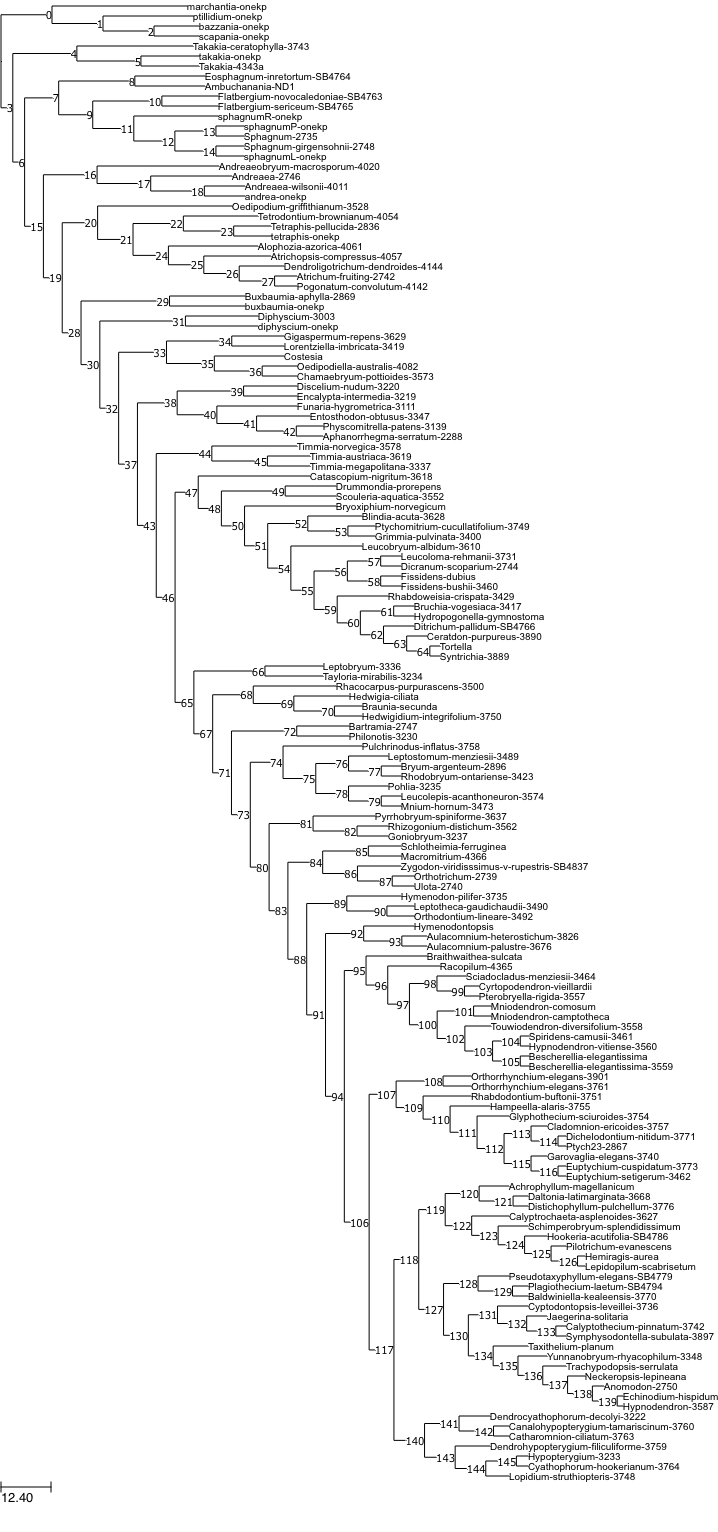

In [5]:
def node_name(node):
    if not node.is_leaf():
        F = TextFace(node.name)
        faces.add_face_to_node(F,node,0,"branch-top")
    
nstyle = NodeStyle()
nstyle["size"] = 0
for n in sptree.traverse():
    n.set_style(nstyle)

sptree.convert_to_ultrametric()  #Makes the tips sorta line up...  
ns = TreeStyle()
ns.layout_fn = node_name
ns.mode="r"
ns.show_leaf_name = True        

sptree.render("%%inline",tree_style=ns)


## Extracting Pie Chart Information

In ETE3, different types of data can be displayed on branches using NodeFaces. How a NodeFace is defined for a particular node is set using a layout function. We need to create list and associate it with each named node.

Two pieces of information are gathered from the "hist" file:

1. The number of gene trees containing the most frequent conflicting toplogy.
2. The total number of concordant and conflicting gene trees.
    
We generate a dictionary of lists containing the pie chart information that will be plotted onto the tree. 
Pie charts are proportions out of the total number trees as set above, with these values in order:

* Proportion concordant
* Proportion conflicting (most frequent conflicting bipartition)
* Proportion conflicting (all other supported conflicting bipartitions)
* The rest



In [6]:
phyparts_hist = [line for line in open(histfile)]

phyparts_pies = {}

phyparts_dict = {}


for n in phyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)[4:]
    concord = float(n.pop(0))
    concord = concord_dict[node_name]
    all_conflict = conflict_dict[node_name]
    
    if len(n) > 0:   
        most_conflict = max([float(x) for x in n])
    else:
        most_conflict = 0.0
    
    adj_concord = (concord/total_genes) * 100 
    adj_most_conflict = (most_conflict/total_genes) * 100
    other_conflict = (all_conflict - most_conflict) / total_genes * 100
    the_rest = (total_genes - concord - all_conflict) / total_genes * 100
    
    pie_list = [adj_concord,adj_most_conflict,other_conflict,the_rest]
        
    phyparts_pies[node_name] = pie_list
    
    phyparts_dict[node_name] = [int(round(concord,0)),int(round(tot_genes-concord,0))]

## Plotting Pie Charts using ETE3

In our layout function, the name of the node is used to extract the appropriate pie chart information. The number of concordant and conflicting gene trees is also extracted. All of these are plotted only if the node is present in the pie chart dictionary (i.e. only if it's an internal node).

We'll use the same colors as the Smith et al. paper in the pies. The species tree is "converted" to ultrametric simply to allow better spacing of the branches-- the branch lengths on this tree are meaningless.


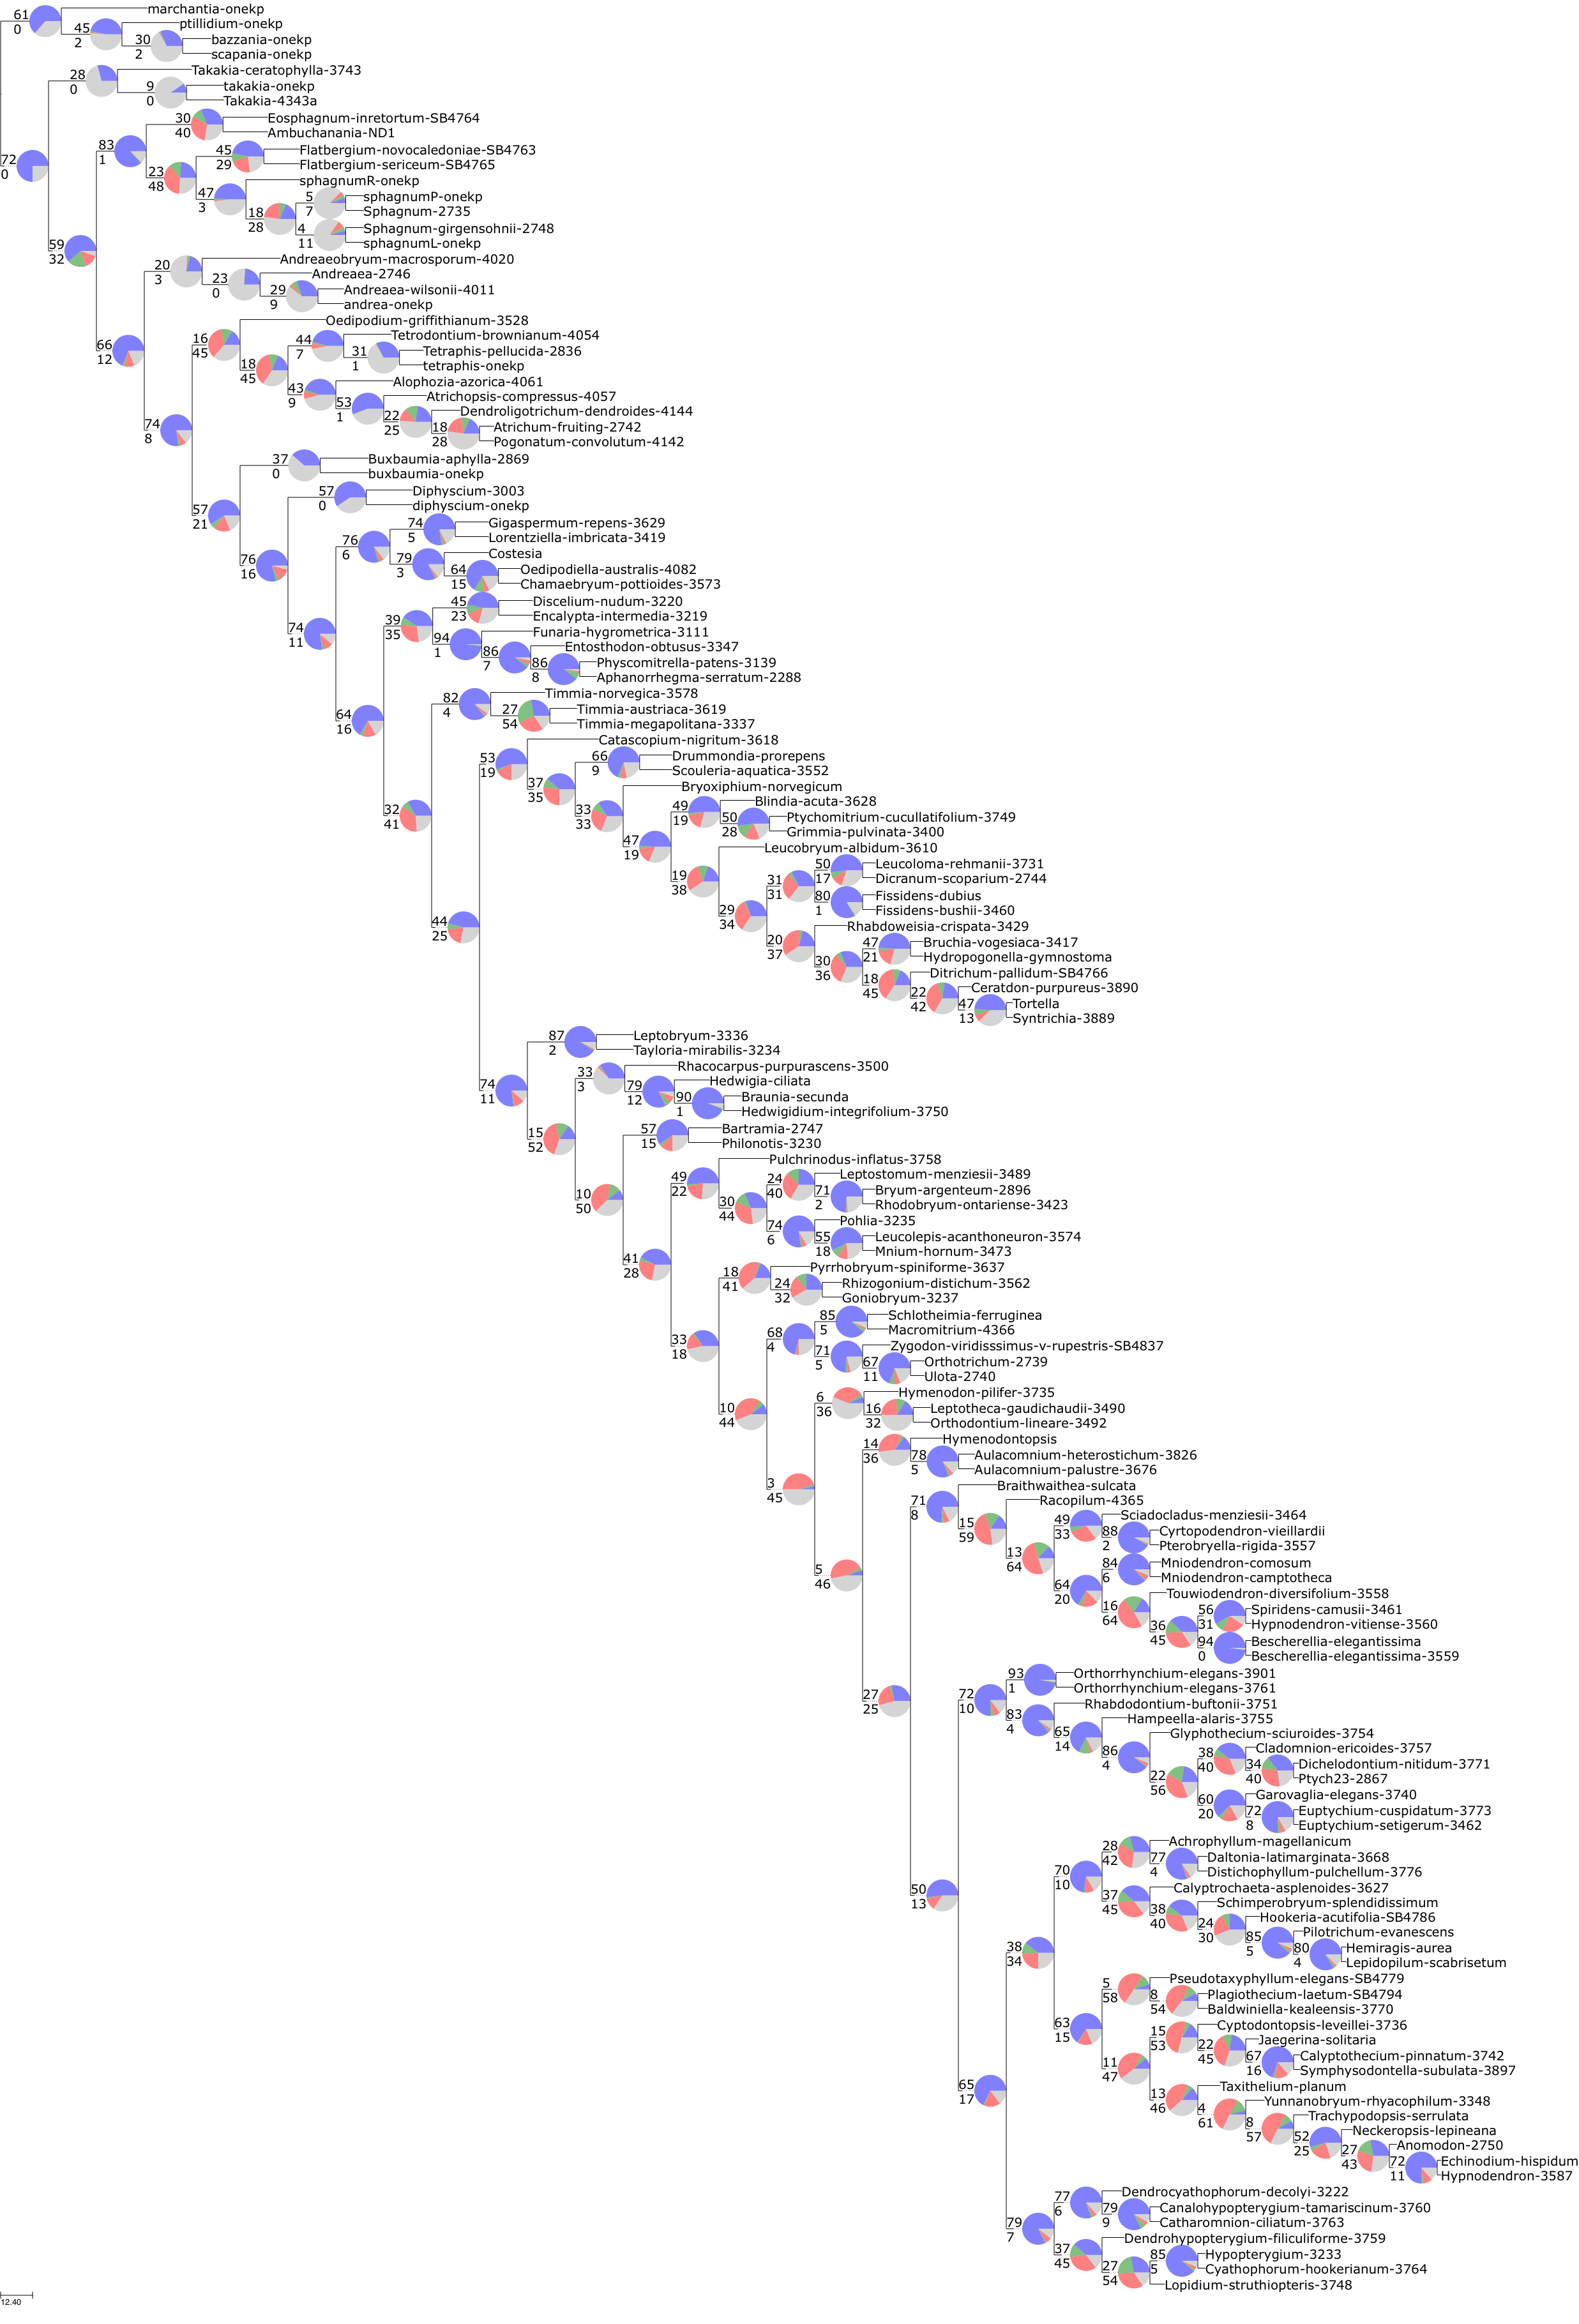

In [7]:
plot_tree = sptree

def phyparts_pie_layout(mynode):
    if mynode.name in phyparts_pies:
        pie= faces.PieChartFace(phyparts_pies[mynode.name],
                              #colors=COLOR_SCHEMES["set1"],
                              colors = ["blue","green","red","dark gray"],
                              width=50, height=50)
        pie.border.width = None
        pie.opacity = 0.5
        faces.add_face_to_node(pie,mynode, 0, position="branch-right")
        
        concord_text = faces.TextFace(int(concord_dict[mynode.name]),fsize=20)
        conflict_text = faces.TextFace(int(conflict_dict[mynode.name]),fsize=20)
        
        faces.add_face_to_node(concord_text,mynode,0,position = "branch-top")
        faces.add_face_to_node(conflict_text,mynode,1,position="branch-bottom")
        
        
    else:
        F = faces.TextFace(mynode.name,fsize=20)
        faces.add_face_to_node(F,mynode,0,position="branch-right")


ts = TreeStyle()
ts.show_leaf_name = False
        
ts.layout_fn = phyparts_pie_layout
ts.mode = "r"
nstyle = NodeStyle()
nstyle["size"] = 0
for n in plot_tree.traverse():
    n.set_style(nstyle)
    n.img_style["vt_line_width"] = 0

    
plot_tree.convert_to_ultrametric()    
#my_svg = plot_tree.render("astral_withpies_fromconcontre.svg",tree_style=ts,w=595) 
plot_tree.render("%%inline",tree_style=ts)

## Implications for the Moss Phylogeny

The moss species phylogeny was generated using ASTRAL. All of the backbone nodes had 100% bootstrap support in a separate RAxML supermatrix analysis. However, there is considerable gene tree conflict at several key nodes. In one case, there are only 3 gene phylogenies supporting the ASTRAL species tree! In some other cases, the "green" portion of the pie chart is substantial, suggesting that an alternative topology should be considered. For example, in the part of the tree shown below, although the ASTRAL tree shows Takakiopsida as sister to the rest of the mosses, this topology is supported by 59 of 96 gene trees. Meanwhile, 17 gene trees (represented in green) have support for a clade containing Takakiopsida and Sphagnopsida as sister to the rest of mosses.

![hi](img/sphag_taka.png)

Which one is right? I'm not entirely certain, but at least we know that conflict exists, and the likely source of it within our data. We would not have had this nuanced view of the moss phylogeny had we relied on bootstrap values alone.

## Thoughts on using ETE3

Some aspects of ETE3 are great, like the ability to modify the tree, rename the nodes, and the extremely flexible Node Face API. Other aspects were challenging, including my failure to recreate a cladogram-style figure despite the `convert_to_ultrametric()` method. It appears that the rescaling of branch lengths does not take into account any Node Faces that may be plotted on a branch, causing the tips to be unaligned. I couldn't quite figure out how to adjust the internal branch lengths to accomodate the pie charts.

ETE3 also requires an X Server (like XQuartz on MacOSX) to draw trees. This is not normally a problem, but it prevented me from using [binder](mybinder.org) to make this Notebook interactive. It also prevents me from running these scripts on a remote machine, even if I just want to save the image file and not view it.




